# import data

In [1]:
import pandas as pd
import os
from datetime import datetime, timedelta, time
stk_code = '603355'
exchange = 'sh_exchange'
folder_path = f'/Users/bokie/code/python/CMS/TWAP优化/trading-optimize/stock_data/{exchange}/{stk_code}'

files_pkl = os.listdir(folder_path)
files_pkl.remove('.DS_Store')
files_pkl
stk_dic = {}
for file in files_pkl:
    tmp_path = folder_path + '/' + file
    df_tmp = pd.read_pickle(tmp_path)
    tmp_key = file[7:15]
    stk_dic[tmp_key] = df_tmp

date = '20220819'
date = '20220822'
# date = '20220826'
# start_date = '20220819'
# end_date = '20220819'
start_date = date
end_date = date
start_date_formatted = start_date[:4] + '-' + start_date[4:6] + '-' + start_date[6:]
end_date_formatted = end_date[:4] + '-' + end_date[4:6] + '-' + end_date[6:]
 
df_stk_orgin = stk_dic[date]


sample_size = 80

In [2]:
stk_clean_dic = {}

for k,v in stk_dic.items():
    v['tmp_index'] = v['date_time'].apply(lambda x:pd.to_datetime(str(x)))
    k_formatted = k[:4] + '-' + k[4:6] + '-' + k[6:]
    stk_clean_dic[k] = v.set_index('tmp_index').loc[f'{k_formatted} 09:30:00':f'{k_formatted} 14:55:00']
    

In [3]:
date_list = list(stk_clean_dic.keys())
date_list.sort()
print(len(date_list))
print(date_list)

81
['20220601', '20220602', '20220606', '20220607', '20220608', '20220609', '20220610', '20220613', '20220614', '20220615', '20220616', '20220617', '20220620', '20220621', '20220622', '20220623', '20220624', '20220627', '20220628', '20220629', '20220630', '20220701', '20220704', '20220705', '20220706', '20220707', '20220708', '20220711', '20220712', '20220713', '20220714', '20220715', '20220718', '20220719', '20220720', '20220721', '20220722', '20220725', '20220726', '20220727', '20220728', '20220729', '20220801', '20220802', '20220803', '20220804', '20220805', '20220808', '20220809', '20220810', '20220811', '20220812', '20220815', '20220816', '20220817', '20220818', '20220819', '20220822', '20220823', '20220824', '20220825', '20220826', '20220829', '20220830', '20220831', '20220901', '20220902', '20220905', '20220906', '20220907', '20220908', '20220909', '20220913', '20220914', '20220915', '20220916', '20220919', '20220920', '20220921', '20220922', '20220923']


# signal calculate

In [4]:
df_threshold = pd.DataFrame([])
df_signal_dic = {}

In [5]:
import numpy as np

pd.set_option('display.max_rows', None)
cols = ['date_time', 
'bid_price1','offer_price1',
'bid_price2','offer_price2',
'bid_price3','offer_price3',
'bid_price4','offer_price4',
'bid_price5','offer_price5',
'bid_order_qty1','offer_order_qty1',
'bid_order_qty2','offer_order_qty2',
'bid_order_qty3','offer_order_qty3',
'bid_order_qty4','offer_order_qty4',
'bid_order_qty5','offer_order_qty5',
'last_px']

for tmp_date in date_list[:sample_size]:
    df_stk_orgin = stk_clean_dic[tmp_date]

    df_signal = pd.DataFrame(data=[],columns=['wt','vt'])

    pre_bid = np.average(df_stk_orgin['bid_price1'].tolist()[0]+df_stk_orgin['bid_price2'].tolist()[0]+\
                        df_stk_orgin['bid_price3'].tolist()[0]+df_stk_orgin['bid_price4'].tolist()[0]+\
                        df_stk_orgin['bid_price5'].tolist()[0])

    pre_offer = np.average(df_stk_orgin['offer_price1'].tolist()[0]+df_stk_orgin['offer_price2'].tolist()[0]+\
                        df_stk_orgin['offer_price3'].tolist()[0]+df_stk_orgin['offer_price4'].tolist()[0]+\
                        df_stk_orgin['offer_price5'].tolist()[0])

    pre_bid_qty = df_stk_orgin['bid_order_qty1'].tolist()[0] + df_stk_orgin['bid_order_qty2'].tolist()[0]+\
                    df_stk_orgin['bid_order_qty3'].tolist()[0]+df_stk_orgin['bid_order_qty4'].tolist()[0]+\
                    df_stk_orgin['bid_order_qty5'].tolist()[0]

    pre_offer_qty = df_stk_orgin['offer_order_qty1'].tolist()[0] + df_stk_orgin['offer_order_qty2'].tolist()[0]+\
                    df_stk_orgin['offer_order_qty3'].tolist()[0] + df_stk_orgin['offer_order_qty4'].tolist()[0]+\
                    df_stk_orgin['offer_order_qty5'].tolist()[0]

    for index,row in df_stk_orgin[cols].set_index('date_time').iterrows():
        bid_qty = row['bid_order_qty1']+row['bid_order_qty2']+row['bid_order_qty3']+row['bid_order_qty4']+row['bid_order_qty5']

        offer_qty = row['offer_order_qty1']+row['offer_order_qty2']+row['offer_order_qty3']+row['offer_order_qty4']+row['offer_order_qty5']

        bid_price = np.average(row['bid_price1']+row['bid_price2']+row['bid_price3']+row['bid_price4']+row['bid_price5'])

        offer_price = np.average(row['offer_price1']+row['offer_price2']+row['offer_price3']+row['offer_price4']+row['offer_price5'])

        if bid_price > pre_bid:
            tmp_wt = np.log(bid_qty)

        # assert False
        elif bid_price == pre_bid:
            tmp_wt = np.log(bid_qty) - np.log(pre_bid_qty)
        elif bid_price < pre_bid:
            tmp_wt = -np.log(pre_bid_qty)
        
        if offer_price > pre_offer:
            tmp_vt = -np.log(pre_offer_qty)
        elif offer_price == pre_offer:
            tmp_vt = np.log(offer_qty) - np.log(pre_offer_qty)
        elif offer_price < pre_offer:
            tmp_vt = np.log(offer_qty)

        df_signal.loc[pd.to_datetime(str(index)),'wt'] = tmp_wt #原始的时间标签是int类型，先转成str再转datetime
        df_signal.loc[pd.to_datetime(str(index)),'vt'] = tmp_vt
        df_signal.loc[pd.to_datetime(str(index)),'price'] = row['last_px']
        pre_bid = bid_price
        pre_offer = offer_price
        pre_bid_qty = bid_qty
        pre_offer_qty = offer_qty
    df_signal['log-OFI'] = df_signal['wt'] - df_signal['vt']
    df_signal['log-OFI-MA50'] = df_signal['log-OFI'].rolling(50).mean()
    df_signal['log-OFI-MA100'] = df_signal['log-OFI'].rolling(100).mean()
    df_signal['log-OFI-MA200'] = df_signal['log-OFI'].rolling(200).mean()
    
    tmp_date_formatted = tmp_date[:4] + '-' + tmp_date[4:6] + '-' + tmp_date[6:]
    incicator_stat = df_signal['log-OFI-MA200'].loc[f'{tmp_date_formatted} 09:30:00':f'{tmp_date_formatted} 14:55:00'].dropna().describe()
    # incicator_stat
    tmp_short_open_threshold = incicator_stat['mean'] + 2*incicator_stat['std']
    tmp_long_open_threshold =  incicator_stat['mean'] - 2*incicator_stat['std']

    df_threshold.loc[tmp_date,'short open'] = tmp_short_open_threshold
    df_threshold.loc[tmp_date,'long open'] = tmp_long_open_threshold

    df_signal_dic[tmp_date] = df_signal
    ####################################################################################################################################
    
 

/var/folders/4y/tm0f5s2n00s3g71c6qrvd0bh0000gn/T/ipykernel_27262/2914655025.py:61: RuntimeWarning: divide by zero encountered in log
  tmp_vt = np.log(offer_qty)
/var/folders/4y/tm0f5s2n00s3g71c6qrvd0bh0000gn/T/ipykernel_27262/2914655025.py:59: RuntimeWarning: divide by zero encountered in log
  tmp_vt = np.log(offer_qty) - np.log(pre_offer_qty)
/var/folders/4y/tm0f5s2n00s3g71c6qrvd0bh0000gn/T/ipykernel_27262/2914655025.py:59: RuntimeWarning: invalid value encountered in double_scalars
  tmp_vt = np.log(offer_qty) - np.log(pre_offer_qty)
/var/folders/4y/tm0f5s2n00s3g71c6qrvd0bh0000gn/T/ipykernel_27262/2914655025.py:57: RuntimeWarning: divide by zero encountered in log
  tmp_vt = -np.log(pre_offer_qty)


In [6]:
df_threshold = df_threshold.shift(1)    

In [7]:
len(date_list)*6

486

In [8]:
df_threshold

,short open,long open
20220601,NaN,NaN
20220602,1.212860,-1.428988
20220606,1.073915,-1.218192
20220607,0.853478,-0.918977
20220608,1.369457,-1.187145
20220609,0.778380,-0.907020
20220610,0.682815,-0.763847
20220613,0.899280,-0.498139
20220614,1.121044,-1.231085
20220615,1.153044,-0.771354


In [9]:
df_threshold.loc['20220615','short open']

1.1530435034561939

In [10]:
df_position_dic = {}
df_signal_bt_dic = {}
for tmp_date in date_list[:sample_size]:
    print(tmp_date)
    df_position = pd.DataFrame(data=[],columns=['pos'])

    short_open_threshold = df_threshold.loc[tmp_date,'short open'] #做空开仓
    short_close_threshold = 0 #做空平仓

    long_close_threshold = -0 #做多平仓
    long_open_threshold = df_threshold.loc[tmp_date,'long open'] #做多开仓

    intraday_open_times = 0
    max_open = 3

    long_open_flag = 0
    short_open_flag = 0

    df_signal = df_signal_dic[tmp_date]
    for index,row in df_signal.iterrows():
        indicator = row['log-OFI-MA200']
        
        if indicator >= short_open_threshold and short_open_flag==0 and long_open_flag==0:
            if intraday_open_times < max_open:
                #diff落在A区间，且无仓位，做空
                short_open_flag = 1
                long_open_flag = 0
                df_position.loc[index,'pos'] = -1*short_open_flag
                intraday_open_times += 1
            else:
                short_open_flag = 0
                long_open_flag = 0
                df_position.loc[index,'pos'] = -1*short_open_flag
        elif indicator >= short_open_threshold and short_open_flag==0 and long_open_flag==1:
            if intraday_open_times < max_open:
                #diff落在A区间，且有多头仓位，平仓再做空
                short_open_flag = 1
                long_open_flag = 0
                df_position.loc[index,'pos'] = -1*short_open_flag
                intraday_open_times += 1
            else:
                short_open_flag = 0
                long_open_flag = 0
                df_position.loc[index,'pos'] = -1*short_open_flag
        elif indicator >= short_open_threshold and short_open_flag==1 and long_open_flag==0:
            #diff落在A区间，且有空头仓位，keep
            short_open_flag = 1
            long_open_flag = 0
            df_position.loc[index,'pos'] = -1*short_open_flag


        if indicator > short_close_threshold and indicator < short_open_threshold and short_open_flag==1 and long_open_flag==0:
            #diff落在B区间，且有空头仓位，keep
            short_open_flag = 1
            long_open_flag = 0
            df_position.loc[index,'pos'] = -1*short_open_flag
        elif indicator > short_close_threshold and indicator < short_open_threshold and short_open_flag==0 and long_open_flag==1:
            #diff落在B区间，且有多头仓位，平仓
            short_open_flag = 0
            long_open_flag = 0
            df_position.loc[index,'pos'] = 1*long_open_flag
        elif indicator > short_close_threshold and indicator < short_open_threshold and short_open_flag==0 and long_open_flag==0:
            #diff落在B区间，且无仓位，keep
            short_open_flag = 0
            long_open_flag = 0
            df_position.loc[index,'pos'] = -1*short_open_flag


        if indicator >= long_close_threshold and indicator <= short_close_threshold and short_open_flag==1 and long_open_flag==0:
            #diff落在C区间，且有空头仓位，平仓
            short_open_flag = 0
            long_open_flag = 0
            df_position.loc[index,'pos'] = -1*short_open_flag
        elif indicator >= long_close_threshold and indicator <= short_close_threshold and short_open_flag==0 and long_open_flag==1:
            #diff落在C区间，且有多头仓位，平仓
            short_open_flag = 0
            long_open_flag = 0
            df_position.loc[index,'pos'] = 1*long_open_flag
        elif indicator >= long_close_threshold and indicator <= short_close_threshold and short_open_flag==0 and long_open_flag==0:        
            #diff落在C区间，且无仓位，keep
            short_open_flag = 0
            long_open_flag = 0
            df_position.loc[index,'pos'] = 1*long_open_flag

        if indicator > long_open_threshold and indicator < long_close_threshold and short_open_flag==1 and long_open_flag==0:
            #diff落在D区间，且有空头仓位，平仓
            short_open_flag = 0
            long_open_flag = 0
            df_position.loc[index,'pos'] = -1*short_open_flag
        elif indicator > long_open_threshold and indicator < long_close_threshold and short_open_flag==0 and long_open_flag==1:
            #diff落在D区间，且有多头仓位，keep
            short_open_flag = 0
            long_open_flag = 1
            df_position.loc[index,'pos'] = 1*long_open_flag
        elif indicator > long_open_threshold and indicator < long_close_threshold and short_open_flag==0 and long_open_flag==0:
            #diff落在D区间，且无仓位，keep
            short_open_flag = 0
            long_open_flag = 0
            df_position.loc[index,'pos'] = 1*long_open_flag

        if indicator <= long_open_threshold and short_open_flag==0 and long_open_flag==0:
            if intraday_open_times < max_open:
                #diff落在E区间，且无仓位，做多
                short_open_flag = 0
                long_open_flag = 1
                df_position.loc[index,'pos'] = 1*long_open_flag
                intraday_open_times += 1
            else:
                short_open_flag = 0
                long_open_flag = 0
                df_position.loc[index,'pos'] = 1*long_open_flag
        elif indicator <= long_open_threshold and short_open_flag==1 and long_open_flag==0:
            if intraday_open_times < max_open:
                #diff落在E区间，且有空头仓位，平仓再做多
                short_open_flag = 0
                long_open_flag = 1
                df_position.loc[index,'pos'] = 1*long_open_flag
                intraday_open_times += 1
            else:
                short_open_flag = 0
                long_open_flag = 0
                df_position.loc[index,'pos'] = 1*long_open_flag
        elif indicator <= long_open_threshold and short_open_flag==0 and long_open_flag==1:
            #diff落在E区间，且有多头仓位，keep
                short_open_flag = 0
                long_open_flag = 1
                df_position.loc[index,'pos'] = 1*long_open_flag
        
        if index.time() > time(14,50,0):
            #每天14:50之后，强制平仓
            short_open_flag = 0
            long_open_flag = 0
            df_position.loc[index,'pos'] = 1*long_open_flag   
            
    # print(df_position.head(2))            
    df_position = pd.concat([df_position,df_signal],axis=1)            
    df_signal_bt = df_position.iloc[0:1,:].append(df_position.dropna())
    df_signal_bt.iloc[0,0] = 0   

    df_position_dic[tmp_date] = df_position.copy(deep=True)        
    df_signal_bt_dic[tmp_date] = df_signal_bt.copy(deep=True)      

20220601
20220602
20220606
20220607
20220608
20220609
20220610
20220613
20220614
20220615
20220616
20220617
20220620
20220621
20220622
20220623
20220624
20220627
20220628
20220629
20220630
20220701
20220704
20220705
20220706
20220707
20220708
20220711
20220712
20220713
20220714
20220715
20220718
20220719
20220720
20220721
20220722
20220725
20220726
20220727
20220728
20220729
20220801
20220802
20220803
20220804
20220805
20220808
20220809
20220810
20220811
20220812
20220815
20220816
20220817
20220818
20220819
20220822
20220823
20220824
20220825
20220826
20220829
20220830
20220831
20220901
20220902
20220905
20220906
20220907
20220908
20220909
20220913
20220914
20220915
20220916
20220919
20220920
20220921
20220922


In [11]:
df_signal_bt_dic.keys()

dict_keys(['20220601', '20220602', '20220606', '20220607', '20220608', '20220609', '20220610', '20220613', '20220614', '20220615', '20220616', '20220617', '20220620', '20220621', '20220622', '20220623', '20220624', '20220627', '20220628', '20220629', '20220630', '20220701', '20220704', '20220705', '20220706', '20220707', '20220708', '20220711', '20220712', '20220713', '20220714', '20220715', '20220718', '20220719', '20220720', '20220721', '20220722', '20220725', '20220726', '20220727', '20220728', '20220729', '20220801', '20220802', '20220803', '20220804', '20220805', '20220808', '20220809', '20220810', '20220811', '20220812', '20220815', '20220816', '20220817', '20220818', '20220819', '20220822', '20220823', '20220824', '20220825', '20220826', '20220829', '20220830', '20220831', '20220901', '20220902', '20220905', '20220906', '20220907', '20220908', '20220909', '20220913', '20220914', '20220915', '20220916', '20220919', '20220920', '20220921', '20220922'])

In [12]:
# df_signal_bt_dic['20220601'].head()

In [13]:
# df_signal_bt_dic['20220602'].head()

In [14]:
# df_signal_bt_dic['20220607'].head()

# backtest

In [15]:
df_trade_dic = {}

In [16]:
for tmp_date in date_list[1:sample_size]:
    print(tmp_date)
    df_signal_bt = df_signal_bt_dic[tmp_date]
    df_trade = pd.DataFrame([])

    cash = 0 #初始账户现金
    stk_hold = 0 #初始股票持有量

    commission_rate = 2/10000
    tax_rate = 1/1000

    stk_volume = 1/3

    for i in range(len(df_signal_bt)-1):

        # df_position的column
        # ['pos','wt','vt','price','log-OFI','log-OFI-MA50','log-OFI-MA100','log-OFI-MA200']
        if df_signal_bt.values[i][0] != df_signal_bt.values[i+1][0]:
            indicator = df_signal_bt.values[i+1][-1]
            # print('record!',df_signal_bt.index[i+1],indicator)
            index = df_signal_bt.index[i+1]
            
            pre_pos = df_signal_bt.values[i][0]
            pos = df_signal_bt.values[i+1][0]
            
            stk_price = df_signal_bt.values[i+1][3]
            commission = commission_rate * stk_price * stk_volume
            if pre_pos == 1:
                tax = tax_rate * stk_price * stk_volume
            else:
                tax = 0

            if pos == 0 and pre_pos == 1:
                cash = cash + stk_price*stk_volume - commission - tax
                stk_hold = 0
                asset_value = 0
            elif pos == 0 and pre_pos == -1:
                cash = cash - stk_price*stk_volume - commission - tax
                stk_hold = 0
                asset_value = 0
            
            elif pos == 1 and pre_pos == 0:
                cash = cash - stk_price*stk_volume - commission - tax
                stk_hold = 1*stk_volume
                asset_value = stk_hold*stk_price
            elif pos == 1 and pre_pos == -1 :
                cash = cash + (stk_price*stk_volume - commission - tax)*2
                stk_hold = 1*stk_volume
                asset_value = stk_hold*stk_price
            
            elif pos == -1 and pre_pos == 0:
                cash = cash + stk_price*stk_volume - commission - tax
                stk_hold = -1*stk_volume
                asset_value = stk_hold*stk_price
            elif pos == -1 and pre_pos == 1:
                cash = cash + (stk_price*stk_volume - commission - tax)*2
                stk_hold = -1*stk_volume
                asset_value = stk_hold*stk_price
            
                
        ########################################################################################################################
    
            df_trade.loc[index,'log-OFI-MA200'] = np.round(indicator,4)
            df_trade.loc[index,'pos'] = pos
            df_trade.loc[index,'stock hold'] = stk_hold
            df_trade.loc[index,'price'] = stk_price
            df_trade.loc[index,'asset value'] = asset_value
            df_trade.loc[index,'cash'] = cash
            df_trade.loc[index,'commission'] = commission
            df_trade.loc[index,'tax'] = tax
    
    # df_trade['net value'] = df_trade['asset value'] + df_trade['cash']
    df_trade_dic[tmp_date] = df_trade

20220602
20220606
20220607
20220608
20220609
20220610
20220613
20220614
20220615
20220616
20220617
20220620
20220621
20220622
20220623
20220624
20220627
20220628
20220629
20220630
20220701
20220704
20220705
20220706
20220707
20220708
20220711
20220712
20220713
20220714
20220715
20220718
20220719
20220720
20220721
20220722
20220725
20220726
20220727
20220728
20220729
20220801
20220802
20220803
20220804
20220805
20220808
20220809
20220810
20220811
20220812
20220815
20220816
20220817
20220818
20220819
20220822
20220823
20220824
20220825
20220826
20220829
20220830
20220831
20220901
20220902
20220905
20220906
20220907
20220908
20220909
20220913
20220914
20220915
20220916
20220919
20220920
20220921
20220922


In [17]:
df_trade_dic.keys()

dict_keys(['20220602', '20220606', '20220607', '20220608', '20220609', '20220610', '20220613', '20220614', '20220615', '20220616', '20220617', '20220620', '20220621', '20220622', '20220623', '20220624', '20220627', '20220628', '20220629', '20220630', '20220701', '20220704', '20220705', '20220706', '20220707', '20220708', '20220711', '20220712', '20220713', '20220714', '20220715', '20220718', '20220719', '20220720', '20220721', '20220722', '20220725', '20220726', '20220727', '20220728', '20220729', '20220801', '20220802', '20220803', '20220804', '20220805', '20220808', '20220809', '20220810', '20220811', '20220812', '20220815', '20220816', '20220817', '20220818', '20220819', '20220822', '20220823', '20220824', '20220825', '20220826', '20220829', '20220830', '20220831', '20220901', '20220902', '20220905', '20220906', '20220907', '20220908', '20220909', '20220913', '20220914', '20220915', '20220916', '20220919', '20220920', '20220921', '20220922'])

In [18]:
df_trade_dic['20220622']

,log-OFI-MA200,pos,stock hold,price,asset value,cash,commission,tax
2022-06-22 10:01:43,0.9838,-1.0,-0.333333,24.50,-8.166667,8.165033,0.001633,0.00000
2022-06-22 10:06:04,-0.0436,0.0,0.000000,24.40,0.000000,0.030073,0.001627,0.00000
2022-06-22 13:04:13,0.9862,-1.0,-0.333333,24.46,-8.153333,8.181776,0.001631,0.00000
2022-06-22 13:23:26,-0.0433,0.0,0.000000,24.50,0.000000,0.013476,0.001633,0.00000
2022-06-22 14:17:45,-1.0164,1.0,0.333333,24.19,8.063333,-8.051470,0.001613,0.00000
2022-06-22 14:45:24,0.0120,0.0,0.000000,24.09,0.000000,-0.031106,0.001606,0.00803


In [19]:
df_trade_dic['20220602']

,log-OFI-MA200,pos,stock hold,price,asset value,cash,commission,tax
2022-06-02 09:52:07,1.2976,-1.0,-0.333333,23.76,-7.920000,7.918416,0.001584,0.000000
2022-06-02 09:55:21,-0.0096,0.0,0.000000,23.59,0.000000,0.053510,0.001573,0.000000
2022-06-02 10:35:16,1.2875,-1.0,-0.333333,23.62,-7.873333,7.925269,0.001575,0.000000
2022-06-02 10:44:39,-0.0898,0.0,0.000000,23.55,0.000000,0.073699,0.001570,0.000000
2022-06-02 10:50:42,-1.5168,1.0,0.333333,23.41,7.803333,-7.731195,0.001561,0.000000
2022-06-02 11:05:53,0.0105,0.0,0.000000,23.44,0.000000,0.072762,0.001563,0.007813


In [20]:
df_trade_dic['20220606']

,log-OFI-MA200,pos,stock hold,price,asset value,cash,commission,tax
2022-06-06 13:11:29,-1.2586,1.0,0.333333,23.51,7.836667,-7.838234,0.001567,0.000000
2022-06-06 13:44:33,0.0535,0.0,0.000000,23.59,0.000000,0.015663,0.001573,0.007863


In [21]:
df_trade_dic['20220607']

,log-OFI-MA200,pos,stock hold,price,asset value,cash,commission,tax
2022-06-07 09:47:09,-0.9628,1.0,0.333333,23.58,7.860000,-7.861572,0.001572,0.00000
2022-06-07 10:04:57,0.0040,0.0,0.000000,23.37,0.000000,-0.080920,0.001558,0.00779
2022-06-07 10:12:07,-0.9219,1.0,0.333333,23.18,7.726667,-7.809132,0.001545,0.00000
2022-06-07 10:24:37,0.1928,0.0,0.000000,23.22,0.000000,-0.078420,0.001548,0.00774
2022-06-07 14:16:24,0.8869,-1.0,-0.333333,23.28,-7.760000,7.680028,0.001552,0.00000
2022-06-07 14:50:02,0.6825,0.0,0.000000,23.34,0.000000,-0.101528,0.001556,0.00000


In [22]:
df_trade_dic['20220608']

""


In [33]:
pd.concat([df_nv,df_threshold.dropna()],axis=1)['net value'].min()

-0.28959799999999924

In [34]:
pd.concat([df_nv,df_threshold.dropna()],axis=1)['net value']

20220602    0.072762
20220606    0.015663
20220607   -0.101528
20220608    0.000000
20220609   -0.000476
20220610   -0.002209
20220613   -0.097500
20220614   -0.099678
20220615   -0.063827
20220616   -0.005743
20220617    0.023535
20220620   -0.071342
20220621    0.010158
20220622   -0.031106
20220623   -0.038780
20220624   -0.111463
20220627   -0.003317
20220628   -0.006029
20220629   -0.031475
20220630   -0.033394
20220701   -0.078221
20220704    0.046697
20220705   -0.031633
20220706    0.099953
20220707   -0.005387
20220708   -0.103469
20220711    0.101014
20220712    0.082098
20220713    0.047293
20220714   -0.027091
20220715    0.042535
20220718   -0.091221
20220719    0.000000
20220720   -0.123419
20220721    0.033870
20220722    0.059809
20220725   -0.016480
20220726    0.040926
20220727    0.033896
20220728    0.388279
20220729    0.130655
20220801    0.216080
20220802    0.195381
20220803   -0.052494
20220804    0.006057
20220805    0.000000
20220808   -0.110665
20220809   -0

<AxesSubplot:>

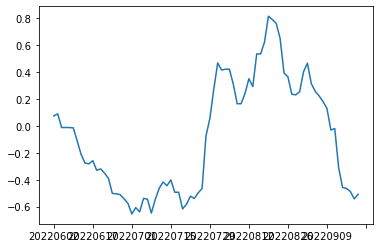

In [30]:
df_nv_dic = {}
df_nv = pd.DataFrame([])
for k,v in df_trade_dic.items():
    if len(v)!=0:
        # print(k,v['cash'].tolist()[-1])
        df_nv.loc[k,'net value'] = v['cash'].tolist()[-1]
    else:
        # print(k,'no trade')
        df_nv.loc[k,'net value'] = 0    
pd.concat([df_nv,df_threshold.dropna()],axis=1).cumsum()['net value'].plot()    

In [25]:
df_nv.sum()

net value   -0.508348
dtype: float64

# position analysis

In [35]:
'''
rgba颜色对照表
https://wenku.baidu.com/view/41c91c5b24284b73f242336c1eb91a37f0113257.html
plotly绘制散点图
https://www.yisu.com/zixun/168081.html
'''
import plotly.graph_objects as go

date_plot = '20220915'
start_date = date_plot
end_date = date_plot
start_date_formatted = start_date[:4] + '-' + start_date[4:6] + '-' + start_date[6:]
end_date_formatted = end_date[:4] + '-' + end_date[4:6] + '-' + end_date[6:]

df_trade = df_trade_dic[date_plot]
df_trade_long = df_trade[df_trade['pos']==1]
df_trade_short = df_trade[df_trade['pos']==-1]
df_trade_close = df_trade[df_trade['pos']==0]


df_signal = df_trade_dic[date_plot]

df_signal = df_position_dic[date_plot]


x_values = df_signal.reset_index()['index'].apply(str)
# x_values = [i for i in range(len(df_signal))]
trace1 = go.Scatter(
    x=x_values,
    y=df_signal['price'].loc[f'{start_date_formatted} 09:30:00':f'{end_date_formatted} 14:55:00'],
    name='price',
    xaxis='x', 
    yaxis='y2',#标明设置一个不同于trace1的一个坐标轴
    mode = 'lines'
)

trace2 = go.Scatter(
    x=x_values,
    y=df_signal['log-OFI-MA200'].loc[f'{start_date_formatted} 09:30:00':f'{end_date_formatted} 14:55:00'],
    name='log-OFI-MA200',
    mode = 'lines'
)


trace_long = go.Scatter(
    x = df_trade_long.index,
    y = df_trade_long['price'],
    xaxis='x', 
    yaxis='y2',#标明设置一个不同于trace1的一个坐标轴
    name = 'long open',
    mode = 'markers',
    marker = dict(
    size = 8, # 设置点的宽度
    color = 'rgba(227, 23, 13, .9)'), #红色
    )

trace_short = go.Scatter(
    x = df_trade_short.index,
    y = df_trade_short['price'],
    xaxis='x', 
    yaxis='y2',#标明设置一个不同于trace1的一个坐标轴
    name = 'short open',
    mode = 'markers',
    marker = dict(
    size =8, # 设置点的宽度
    color = 'rgba(151, 51, 250, .9)'), #紫色
    )

trace_close = go.Scatter(
    x = df_trade_close.index,
    y = df_trade_close['price'],
    xaxis='x', 
    yaxis='y2',#标明设置一个不同于trace1的一个坐标轴
    name = 'close',
    mode = 'markers',
    marker = dict(
    size = 8, # 设置点的宽度
    color = 'rgba(0, 255, 0, .9)'), #绿色
    )

data = [trace1,trace2,trace_long,trace_short,trace_close]
layout = go.Layout({"template": 'simple_white',
                   "title":{"text": 'price & log-OFI-MA', "x": 0.5}, 
                   "xaxis":{"title": {"text": None}, "tickformat": ''},
                   "yaxis":{"title": {"text": ""}},
                   "yaxis2": {'anchor': 'x', "overlaying": 'y', "side": 'right'}, #设置坐标轴的格式，一般次坐标轴在右侧
                   "legend":{"title": {"text": ""}, "x": 0.9, "y": 1.1},
                   "width": 1200,
                   "height": 500})
 
fig = go.Figure(data=data, layout=layout)
fig.show()

df_trade['net value'] = df_trade['asset value'] + df_trade['cash']
x_values = df_trade['net value'].index
# x_values = [i for i in range(len(df_trade))]

fig = go.Figure(data=[
    go.Scatter(name='log-OFI', x=x_values, y=df_trade['net value']),
],
)
fig.show() 
